In [46]:
import pandas as pd
import numpy as np
from gensim.models import Doc2Vec

import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")




/Users/Tinmar/anaconda3/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
#!pip install seaborn

In [4]:
df = pd.read_csv('consumer_complaints/Consumer_Complaints.csv')
df = df[['Consumer complaint narrative','Product']]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)
df.reset_index(drop=True,inplace=True)
df.head(10)


,narrative,Product
0,I am dissatisfied with the current outcome of ...,Credit card
1,On XX/XX/18 an item showed up on my credit rep...,"Credit reporting, credit repair services, or o..."
2,Saw on my credit report that there is a collec...,Debt collection
3,Capital one auto finacing XX/XX/2018 unknown i...,"Credit reporting, credit repair services, or o..."
4,I own a small trucking company. One of my truc...,Credit card or prepaid card
5,"XX/XX/XXXX, I was working as a XXXX in the XXX...",Mortgage
6,I have a public record & Child Support entry t...,"Credit reporting, credit repair services, or o..."
7,"On XX/XX/XXXX, I received a letter from Harris...",Debt collection
8,XXXX has once again furnished ficticious and d...,"Credit reporting, credit repair services, or o..."
9,Complaint against SUNTRUST MORTGAGE in regards...,Mortgage


In [5]:
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

95101153

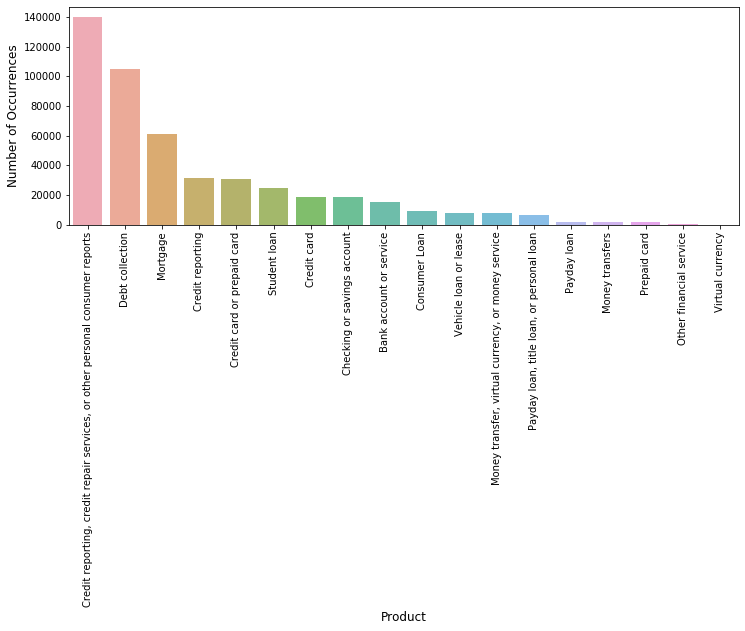

In [6]:
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [7]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

print_complaint(12)

I moved to XXXX XXXX last year, but was traveling a lot for work and ended up moving to XXXX XXXX. I wanted to open a credit account to build a strong credit score so when I was buying stuff at XXXX XXXX, I signed up for their credit card system not knowing they had put an outstanding balance of XXXX XXXX This was 8 months ago. I never received the credit card, therefore I still to this day have never used the card and have no idea where it is. Then I started getting calls from 'unknown ' saying I had to pay XXXX $ about 3 months ago, so I thought it was a fraud because they didn't specify where they were coming from. Then more unknown, or random numbers were calling me saying I owe XXXX $ to XXXX XXXX. I explained to them I have no idea why I would owe them that because I never received the card therefore I couldn't go online to pay whatever outstanding balance was on my card because I couldn't sign in without the credit card number and information in the package that was supposed to 

## text preprocessing

In [8]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    #text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'\w+/\w+/\w+', r' ',text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text


In [9]:
df['narrative'] = df['narrative'].progress_apply(cleanText)

progress-bar: 100%|██████████| 481404/481404 [03:39<00:00, 2193.33it/s]


In [10]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [11]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.progress_apply(lambda r: \
           TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

test_tagged = test.progress_apply(lambda r: \
           TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

progress-bar: 100%|██████████| 144422/144422 [05:49<00:00, 413.49it/s]


In [13]:
train_tagged.iloc[0]

TaggedDocument(words=['amounts', 'listed', 'on', 'multiple', 'accounts', 'are', 'incorrect', 'have', 'opened', 'dispute', 'because', 'student', 'loan', 'account', 'were', 'being', 'reported', 'different', 'times', 'and', 'different', 'amounts', 'auto', 'loan', 'and', 'credit', 'cards', 'balance', 'are', 'not', 'correct', 'reporting', 'charge', 'that', 'is', 'paid', 'as', 'unpaid', 'just', 'recently', 'again', 'requested', 'this', 'information', 'to', 'be', 'updated'], tags=['Credit reporting, credit repair services, or other personal consumer reports'])

In [17]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

4

In [23]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=5, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 336982/336982 [00:00<00:00, 1156470.70it/s]


In [32]:
%%time
#for epoch in range(30):
#    print('epoch {}'.format(epoch+1))
model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), 
                 total_examples=len(train_tagged.values), 
                 epochs=2)
#model_dbow.alpha -= 0.002
#model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 336982/336982 [00:00<00:00, 1739425.47it/s]


CPU times: user 6min 47s, sys: 12.3 s, total: 6min 59s
Wall time: 3min 22s


In [33]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors



In [48]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

KeyboardInterrupt: 

In [47]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

NameError: name 'X_train' is not defined

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)